<a href="https://colab.research.google.com/github/gzhang31/chess_vision_bot/blob/main/CSC490_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: We are starting by recreating some open source models

https://github.com/csrhddlam/axial-deeplab

https://openreview.net/forum?id=YicbFdNTTy

As well as using pre-trained vision models such as ViT (vision transformer)
and fine tuning


In [ ]:
!pip install transformers

Mounted at /content/drive
/content/drive/MyDrive/test


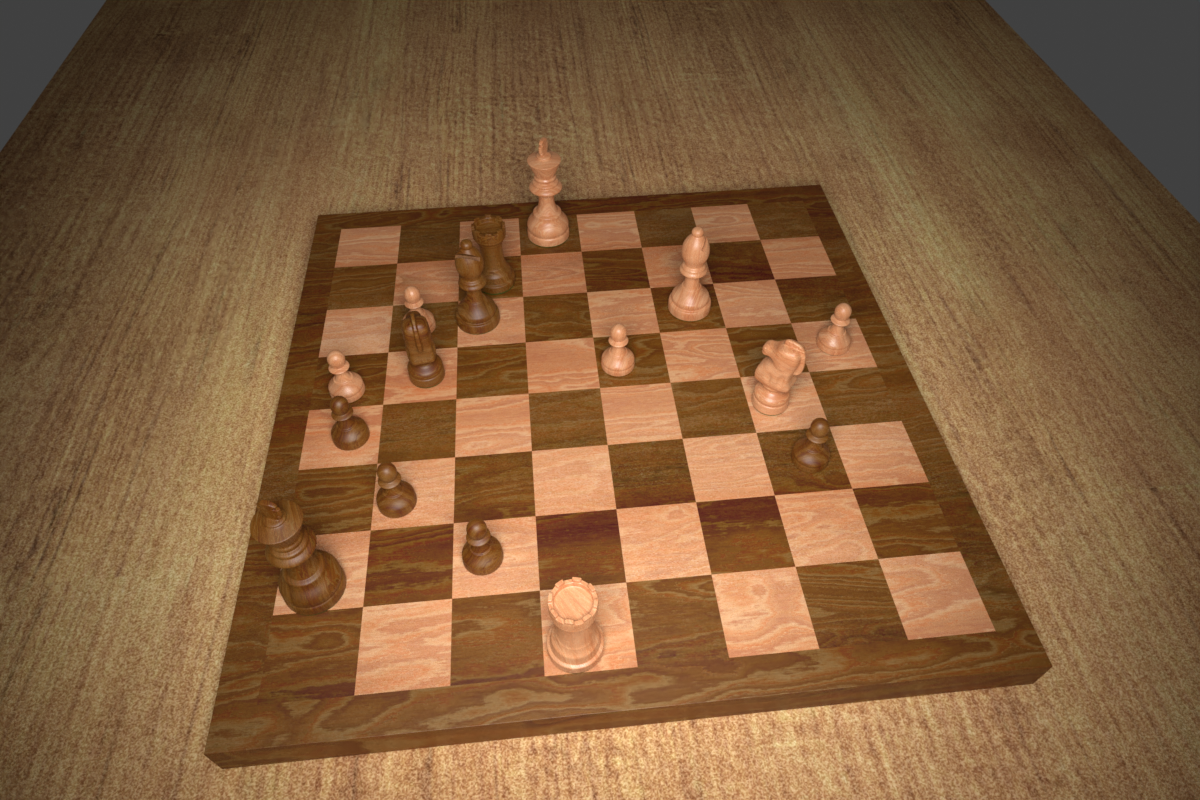

'\nfor i in range(10):\n  img = cv2.imread("/content/drive/MyDrive/test/" + image_files[i])\n  cv2_imshow(img)\n'

In [ ]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

test_folder = '/content/drive/MyDrive/test'

print(test_folder)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = [f for f in os.listdir(test_folder)
               if any(f.lower().endswith(ext) for ext in image_extensions)]
#print(image_files)
test_img = cv2.imread("/content/drive/MyDrive/test/1025.png")
cv2_imshow(test_img)
'''
for i in range(10):
  img = cv2.imread("/content/drive/MyDrive/test/" + image_files[i])
  cv2_imshow(img)
'''



Function to convert JSON data into chessboard array

In [ ]:
import json
def fen_to_chessboard(json_data):
    """
    Convert FEN string from JSON to an 8x8 chessboard array.

    Args:
        json_data: Dictionary containing 'fen' key with FEN string

    Returns:
        8x8 list representing the chessboard, where:
        - 'x' or '.' represents empty squares
        - Uppercase letters (K, Q, R, B, N, P) are white pieces
        - Lowercase letters (k, q, r, b, n, p) are black pieces
    """

    # Handle both dict and JSON string input
    if isinstance(json_data, str):
        json_data = json.loads(json_data)

    fen = json_data['fen']

    # Split FEN string - we only need the first part (piece positions)
    board_fen = fen.split()[0] if ' ' in fen else fen

    # Split into ranks (rows)
    ranks = board_fen.split('/')

    board = []
    for rank in ranks:
        row = []
        for char in rank:
            if char.isdigit():
                # Number represents empty squares
                row.extend(['x'] * int(char))
            else:
                # Letter represents a piece
                row.append(char)
        board.append(row)

    return board


def print_chessboard(board):
    """Pretty print the chessboard."""
    print("  a b c d e f g h")
    for i, row in enumerate(board):
        print(f"{8-i} {' '.join(row)} {8-i}")
    print("  a b c d e f g h")


def chessboard_to_tensor_labels(board, piece_to_idx):
    """
    Convert chessboard to label tensor for training.

    Args:
        board: 8x8 list from fen_to_chessboard()
        piece_to_idx: Dictionary mapping pieces to indices

    Returns:
        Flattened list of 64 labels (0-12)
    """
    labels = []
    for row in board:
        for piece in row:
            labels.append(piece_to_idx[piece])
    return labels

In [ ]:
# Code credit: VALUE-Dataset https://github.com/espressoVi/VALUE-Dataset/blob/master/baselines/models/classifiers.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights
from transformers import ViTModel, SwinModel

class ChessBoardResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "resnet50"
        self.piece_to_idx = {'x': 0, 'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                             'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12}
        self.class_num = len(self.piece_to_idx)
        board_dim = 8
        self.fex = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.fex.fc.weight.shape[1]
        out_features = board_dim*board_dim*self.class_num
        self.fex.fc = nn.Identity()
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(in_features,out_features)
        self.loss = nn.CrossEntropyLoss()
    def forward(self, images, labels = None):
        x = self.fex(images)
        x = self.dropout(x)
        x = self.fc(x).view(x.shape[0],self.class_num, -1)
        predicts = torch.argmax(torch.softmax(x, dim = 1), dim = 1)
        if not self.training:
            return predicts
        loss = self.loss(x, labels)
        return loss, predicts



In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            loss, predicts = model(images, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (predicts == labels).sum().item()
            train_total += labels.numel()

        train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                loss, predicts = model(images, labels)

                val_loss += loss.item()
                val_correct += (predicts == labels).sum().item()
                val_total += labels.numel()

        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
        print('-' * 50)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/test


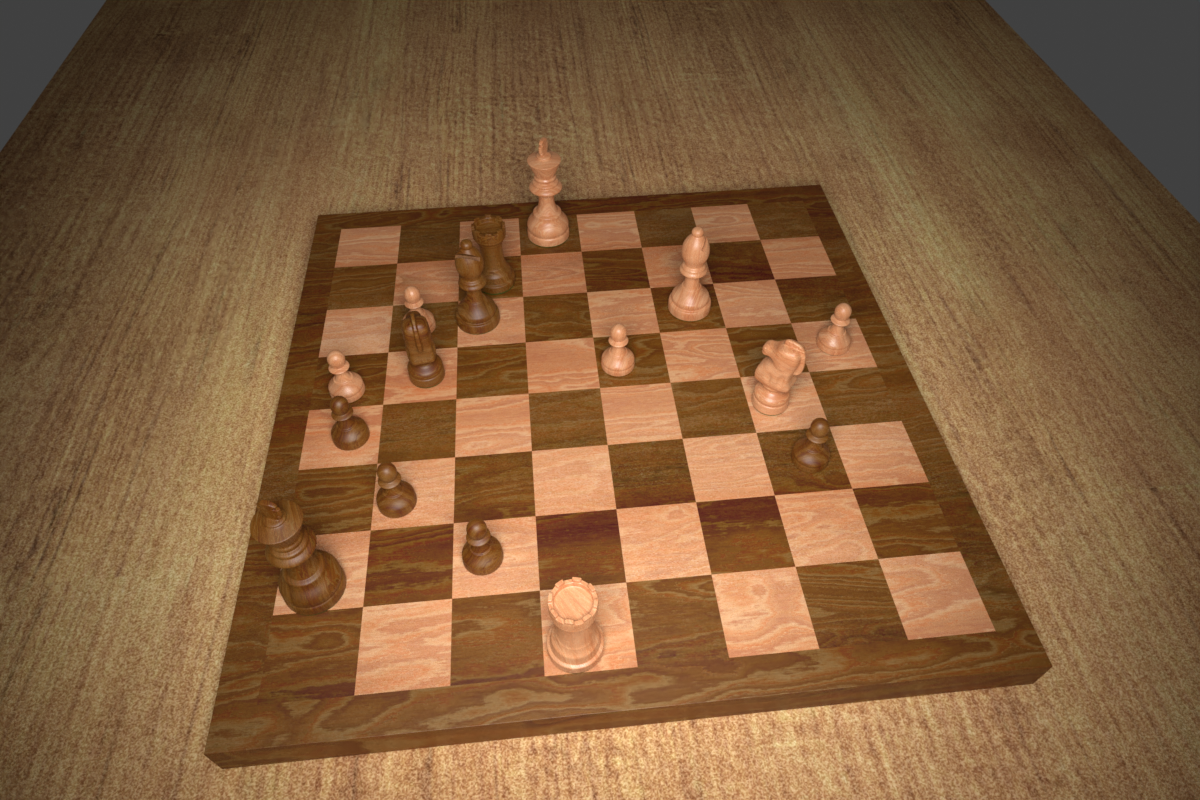

In [ ]:
# Process images into tensors
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

test_folder = '/content/drive/MyDrive/test'

print(test_folder)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = [f for f in os.listdir(test_folder)
               if any(f.lower().endswith(ext) for ext in image_extensions)]
#print(image_files)
test_img = cv2.imread("/content/drive/MyDrive/test/1025.png")
cv2_imshow(test_img)
from torchvision import transforms
image_to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),           # Convert to tensor and scale to [0, 1]
])
dataset_tensors = []
for image in image_files:
  image_path = os.path.join(test_folder, image)
  image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 channels

  # Apply transforms
  tensor = image_to_tensor(image)
  dataset_tensors.append(tensor)

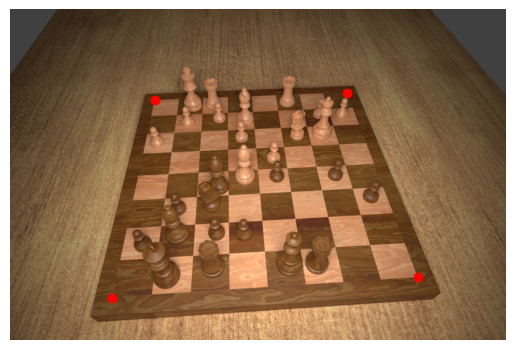

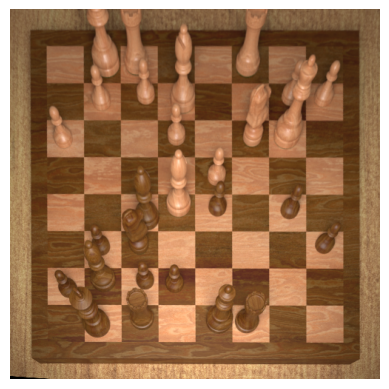

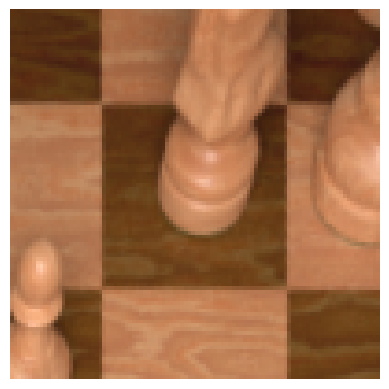

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import cv2
import numpy as np
import typing

RESIZE_IMAGE_WIDTH = 1200
LINE_DETECTION_THRESHOLD = 150
LINE_DETECTION_DIAGONAL_LINE_ELIMINATION = True
LINE_DETECTION_DIAGONAL_LINE_ELIMINATION_THRESHOLD_DEGREES = 30
RANSAC_OFFSET_TOLERANCE = 0.1
RANSAC_BEST_SOLUTION_TOLERANCE = 0.15
MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE = 0.7
BORDER_REFINEMENT_NUM_SURROUNDING_SQUARES_IN_WARPED_IMG = 5
BORDER_REFINEMENT_WARPED_SQUARE_SIZE = [50, 50]
BORDER_REFINEMENT_SOBEL_KERNEL_SIZE = 3
BORDER_REFINEMENT_LINE_WIDTH = 4
SQUARE_SIZE = 50
BOARD_SIZE = 8 * SQUARE_SIZE
IMG_SIZE = BOARD_SIZE + 2 * SQUARE_SIZE

class edge_detection ():
    def __init__(self, aperture, thresh_high, thresh_low):
        self.aperture = aperture
        self.thresh_high = thresh_high
        self.thresh_low = thresh_low

EDGE_DETECTION = edge_detection(aperture=3, thresh_high=400, thresh_low=90)
VERTICAL_BORDER_DETECTION = edge_detection(aperture=3, thresh_high=200, thresh_low=100)
HORIZONTAL_BORDER_DETECTION = edge_detection(aperture=3, thresh_high=300, thresh_low=120)

def to_homogenous_coordinates(coordinates: np.ndarray) -> np.ndarray:
    """Convert Cartesian to homogenous coordinates.

    Args:
        coordinates (np.ndarray): the Cartesian coordinates (shape: [..., 2])

    Returns:
        np.ndarray: the homogenous coordinates (shape: [..., 3])
    """
    return np.concatenate([coordinates,
                           np.ones((*coordinates.shape[:-1], 1))], axis=-1)


def from_homogenous_coordinates(coordinates: np.ndarray) -> np.ndarray:
    """Convert homogenous to Cartesian coordinates.

    Args:
        coordinates (np.ndarray): the homogenous coordinates (shape: [..., 3])

    Returns:
        np.ndarray: the Cartesian coordinates (shape: [..., 2])
    """
    return coordinates[..., :2] / coordinates[..., 2, np.newaxis]

def find_corners(img: np.ndarray) -> np.ndarray:
    """Determine the four corner points of the chessboard in an image.

    Args:
        img (np.ndarray): the input image (as a numpy array)

    Raises:
        ChessboardNotLocatedException: if the chessboard could not be found

    Returns:
        np.ndarray: the pixel coordinates of the four corners
    """
    img, img_scale = resize_image(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = _detect_edges(EDGE_DETECTION, gray)
    lines = _detect_lines(edges)
    if lines.shape[0] > 400:
        raise ChessboardNotLocatedException("too many lines in the image")
    all_horizontal_lines, all_vertical_lines = _cluster_horizontal_and_vertical_lines(
        lines)

    horizontal_lines = _eliminate_similar_lines(
        all_horizontal_lines, all_vertical_lines)
    vertical_lines = _eliminate_similar_lines(
        all_vertical_lines, all_horizontal_lines)

    all_intersection_points = _get_intersection_points(horizontal_lines,
                                                       vertical_lines)

    best_num_inliers = 0
    best_configuration = None
    iterations = 0
    while iterations < 200 or best_num_inliers < 30:
        row1, row2 = _choose_from_range(len(horizontal_lines))
        col1, col2 = _choose_from_range(len(vertical_lines))
        transformation_matrix = _compute_homography(all_intersection_points,
                                                    row1, row2, col1, col2)
        warped_points = _warp_points(
            transformation_matrix, all_intersection_points)
        warped_points, intersection_points, horizontal_scale, vertical_scale = _discard_outliers(
            warped_points, all_intersection_points)
        num_inliers = np.prod(warped_points.shape[:-1])
        if num_inliers > best_num_inliers:
            warped_points *= np.array((horizontal_scale, vertical_scale))

            # Quantize and reject deuplicates
            (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = configuration = _quantize_points(
                warped_points, intersection_points)

            # Calculate remaining number of inliers
            num_inliers = np.prod(quantized_points.shape[:-1])

            if num_inliers > best_num_inliers:
                best_num_inliers = num_inliers
                best_configuration = configuration
        iterations += 1
        if iterations > 10000:
            raise ChessboardNotLocatedException(
                "RANSAC produced no viable results")

    # Retrieve best configuration
    (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = best_configuration

    # Recompute transformation matrix based on all inliers
    transformation_matrix = compute_transformation_matrix(
        intersection_points, quantized_points)
    inverse_transformation_matrix = np.linalg.inv(transformation_matrix)

    # Warp grayscale image
    dims = tuple(warped_img_size.astype(np.int32))
    warped = cv2.warpPerspective(gray, transformation_matrix, dims)
    borders = np.zeros_like(gray)
    borders[3:-3, 3:-3] = 1
    warped_borders = cv2.warpPerspective(borders, transformation_matrix, dims)
    warped_mask = warped_borders == 1

    # Refine board boundaries
    xmin, xmax = _compute_vertical_borders(
        warped, warped_mask, scale, xmin, xmax)
    scaled_xmin, scaled_xmax = (int(x * scale[0]) for x in (xmin, xmax))
    warped_mask[:, :scaled_xmin] = warped_mask[:, scaled_xmax:] = False
    ymin, ymax = _compute_horizontal_borders(
        warped, warped_mask, scale, ymin, ymax)

    # Transform boundaries to image space
    corners = np.array([[xmin, ymin],
                        [xmax, ymin],
                        [xmax, ymax],
                        [xmin, ymax]]).astype(np.float32)
    corners = corners * scale
    img_corners = _warp_points(inverse_transformation_matrix, corners)
    img_corners = img_corners / img_scale
    return sort_corner_points(img_corners)


def resize_image(img: np.ndarray) -> typing.Tuple[np.ndarray, float]:
    """Resize an image for use in the corner detection pipeline, maintaining the aspect ratio.

    Args:
        img (np.ndarray): the input image

    Returns:
        typing.Tuple[np.ndarray, float]: the resized image along with the scale of this new image
    """
    h, w, _ = img.shape
    if w == RESIZE_IMAGE_WIDTH:
        return img, 1
    scale = RESIZE_IMAGE_WIDTH / w
    dims = (RESIZE_IMAGE_WIDTH, int(h * scale))

    img = cv2.resize(img, dims)
    return img, scale


def _detect_edges(edge_detection_cfg: edge_detection, gray: np.ndarray) -> np.ndarray:
    if gray.dtype != np.uint8:
        gray = gray / gray.max() * 255
        gray = gray.astype(np.uint8)
    edges = cv2.Canny(gray,
                      edge_detection_cfg.thresh_low,
                      edge_detection_cfg.thresh_high,
                      edge_detection_cfg.aperture)
    return edges


def _detect_lines(edges: np.ndarray) -> np.ndarray:
    # array of [rho, theta]
    lines = cv2.HoughLines(edges, 1, np.pi/360, LINE_DETECTION_THRESHOLD)
    lines = lines.squeeze(axis=-2)
    lines = _fix_negative_rho_in_hesse_normal_form(lines)

    if LINE_DETECTION_DIAGONAL_LINE_ELIMINATION:
        threshold = np.deg2rad(
            LINE_DETECTION_DIAGONAL_LINE_ELIMINATION_THRESHOLD_DEGREES)
        vmask = np.abs(lines[:, 1]) < threshold
        hmask = np.abs(lines[:, 1] - np.pi / 2) < threshold
        mask = vmask | hmask
        lines = lines[mask]
    return lines


def _fix_negative_rho_in_hesse_normal_form(lines: np.ndarray) -> np.ndarray:
    lines = lines.copy()
    neg_rho_mask = lines[..., 0] < 0
    lines[neg_rho_mask, 0] = - \
        lines[neg_rho_mask, 0]
    lines[neg_rho_mask, 1] =  \
        lines[neg_rho_mask, 1] - np.pi
    return lines


def _absolute_angle_difference(x, y):
    diff = np.mod(np.abs(x - y), 2*np.pi)
    return np.min(np.stack([diff, np.pi - diff], axis=-1), axis=-1)


def _sort_lines(lines: np.ndarray) -> np.ndarray:
    if lines.ndim == 0 or lines.shape[-2] == 0:
        return lines
    rhos = lines[..., 0]
    sorted_indices = np.argsort(rhos)
    return lines[sorted_indices]


def _cluster_horizontal_and_vertical_lines(lines: np.ndarray):
    lines = _sort_lines(lines)
    thetas = lines[..., 1].reshape(-1, 1)
    distance_matrix = pairwise_distances(
        thetas, thetas, metric=_absolute_angle_difference)
    agg = AgglomerativeClustering(n_clusters=2, metric="precomputed",
                                  linkage="average")
    clusters = agg.fit_predict(distance_matrix)

    angle_with_y_axis = _absolute_angle_difference(thetas, 0.)
    if angle_with_y_axis[clusters == 0].mean() > angle_with_y_axis[clusters == 1].mean():
        hcluster, vcluster = 0, 1
    else:
        hcluster, vcluster = 1, 0

    horizontal_lines = lines[clusters == hcluster]
    vertical_lines = lines[clusters == vcluster]

    return horizontal_lines, vertical_lines


def _eliminate_similar_lines(lines: np.ndarray, perpendicular_lines: np.ndarray) -> np.ndarray:
    perp_rho, perp_theta = perpendicular_lines.mean(axis=0)
    rho, theta = np.moveaxis(lines, -1, 0)
    intersection_points = get_intersection_point(
        rho, theta, perp_rho, perp_theta)
    intersection_points = np.stack(intersection_points, axis=-1)

    clustering = DBSCAN(eps=12, min_samples=1).fit(intersection_points)

    filtered_lines = []
    for c in range(clustering.labels_.max() + 1):
        lines_in_cluster = lines[clustering.labels_ == c]
        rho = lines_in_cluster[..., 0]
        median = np.argsort(rho)[len(rho)//2]
        filtered_lines.append(lines_in_cluster[median])
    return np.stack(filtered_lines)


def get_intersection_point(rho1: np.ndarray, theta1: np.ndarray, rho2: np.ndarray, theta2: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray]:
    """Obtain the intersection point of two lines in Hough space.

    This method can be batched

    Args:
        rho1 (np.ndarray): first line's rho
        theta1 (np.ndarray): first line's theta
        rho2 (np.ndarray): second lines's rho
        theta2 (np.ndarray): second line's theta

    Returns:
        typing.Tuple[np.ndarray, np.ndarray]: the x and y coordinates of the intersection point(s)
    """
    # rho1 = x cos(theta1) + y sin(theta1)
    # rho2 = x cos(theta2) + y sin(theta2)
    cos_t1 = np.cos(theta1)
    cos_t2 = np.cos(theta2)
    sin_t1 = np.sin(theta1)
    sin_t2 = np.sin(theta2)
    x = (sin_t1 * rho2 - sin_t2 * rho1) / (cos_t2 * sin_t1 - cos_t1 * sin_t2)
    y = (cos_t1 * rho2 - cos_t2 * rho1) / (sin_t2 * cos_t1 - sin_t1 * cos_t2)
    return x, y


def _choose_from_range(upper_bound: int, n: int = 2):
    return np.sort(np.random.choice(np.arange(upper_bound), (n,), replace=False), axis=-1)


def _get_intersection_points(horizontal_lines: np.ndarray, vertical_lines: np.ndarray) -> np.ndarray:
    rho1, theta1 = np.moveaxis(horizontal_lines, -1, 0)
    rho2, theta2 = np.moveaxis(vertical_lines, -1, 0)

    rho1, rho2 = np.meshgrid(rho1, rho2, indexing="ij")
    theta1, theta2 = np.meshgrid(theta1, theta2, indexing="ij")
    intersection_points = get_intersection_point(rho1, theta1, rho2, theta2)
    intersection_points = np.stack(intersection_points, axis=-1)
    return intersection_points


def compute_transformation_matrix(src_points: np.ndarray, dst_points: np.ndarray) -> np.ndarray:
    """Compute the transformation matrix based on source and destination points.

    Args:
        src_points (np.ndarray): the source points (shape: [..., 2])
        dst_points (np.ndarray): the source points (shape: [..., 2])

    Returns:
        np.ndarray: the transformation matrix
    """
    transformation_matrix, _ = cv2.findHomography(src_points.reshape(-1, 2),
                                                  dst_points.reshape(-1, 2))
    return transformation_matrix


def _compute_homography(intersection_points: np.ndarray, row1: int, row2: int, col1: int, col2: int):
    p1 = intersection_points[row1, col1]  # top left
    p2 = intersection_points[row1, col2]  # top right
    p3 = intersection_points[row2, col2]  # bottom right
    p4 = intersection_points[row2, col1]  # bottom left

    src_points = np.stack([p1, p2, p3, p4])
    dst_points = np.array([[0, 0],  # top left
                           [1, 0],  # top right
                           [1, 1],  # bottom right
                           [0, 1]])  # bottom left
    return compute_transformation_matrix(src_points, dst_points)


def _warp_points(transformation_matrix: np.ndarray, points: np.ndarray) -> np.ndarray:
    points = to_homogenous_coordinates(points)
    warped_points = points @ transformation_matrix.T
    return from_homogenous_coordinates(warped_points)


def _find_best_scale(values: np.ndarray, scales: np.ndarray = np.arange(1, 9)):
    scales = np.sort(scales)
    scaled_values = np.expand_dims(values, axis=-1) * scales
    diff = np.abs(np.rint(scaled_values) - scaled_values)

    inlier_mask = diff < RANSAC_OFFSET_TOLERANCE / scales
    num_inliers = np.sum(inlier_mask, axis=tuple(range(inlier_mask.ndim - 1)))

    best_num_inliers = np.max(num_inliers)

    # We will choose a slightly worse scale if it is lower
    index = np.argmax(num_inliers > (
        1 - RANSAC_BEST_SOLUTION_TOLERANCE) * best_num_inliers)
    return scales[index], inlier_mask[..., index]


def _discard_outliers(warped_points: np.ndarray, intersection_points: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, float, float]:
    horizontal_scale, horizontal_mask = _find_best_scale(warped_points[..., 0])
    vertical_scale, vertical_mask = _find_best_scale(warped_points[..., 1])
    mask = horizontal_mask & vertical_mask

    # Keep rows/cols that have more than 50% inliers
    num_rows_to_consider = np.any(mask, axis=-1).sum()
    num_cols_to_consider = np.any(mask, axis=-2).sum()
    rows_to_keep = mask.sum(axis=-1) / num_rows_to_consider > \
        MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE
    cols_to_keep = mask.sum(axis=-2) / num_cols_to_consider > \
        MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE

    warped_points = warped_points[rows_to_keep][:, cols_to_keep]
    intersection_points = intersection_points[rows_to_keep][:, cols_to_keep]
    return warped_points, intersection_points, horizontal_scale, vertical_scale


def _quantize_points(warped_scaled_points: np.ndarray, intersection_points: np.ndarray) -> typing.Tuple[tuple, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    mean_col_xs = warped_scaled_points[..., 0].mean(axis=0)
    mean_row_ys = warped_scaled_points[..., 1].mean(axis=1)

    col_xs = np.rint(mean_col_xs).astype(np.int32)
    row_ys = np.rint(mean_row_ys).astype(np.int32)

    # Remove duplicates
    col_xs, col_indices = np.unique(col_xs, return_index=True)
    row_ys, row_indices = np.unique(row_ys, return_index=True)
    intersection_points = intersection_points[row_indices][:, col_indices]

    # Compute mins and maxs in warped space
    xmin = col_xs.min()
    xmax = col_xs.max()
    ymin = row_ys.min()
    ymax = row_ys.max()

    # Ensure we a have a maximum of 9 rows/cols
    while xmax - xmin > 8:
        xmax -= 1
        xmin += 1
    while ymax - ymin > 8:
        ymax -= 1
        ymin += 1
    col_mask = (col_xs >= xmin) & (col_xs <= xmax)
    row_mask = (row_ys >= xmin) & (row_ys <= xmax)

    # Discard
    col_xs = col_xs[col_mask]
    row_ys = row_ys[row_mask]
    intersection_points = intersection_points[row_mask][:, col_mask]

    # Create quantized points array
    quantized_points = np.stack(np.meshgrid(col_xs, row_ys), axis=-1)

    # Transform in warped space
    translation = -np.array([xmin, ymin]) + \
        BORDER_REFINEMENT_NUM_SURROUNDING_SQUARES_IN_WARPED_IMG
    scale = np.array(BORDER_REFINEMENT_WARPED_SQUARE_SIZE)

    scaled_quantized_points = (quantized_points + translation) * scale
    xmin, ymin = np.array((xmin, ymin)) + translation
    xmax, ymax = np.array((xmax, ymax)) + translation
    warped_img_size = (np.array((xmax, ymax)) +
                       BORDER_REFINEMENT_NUM_SURROUNDING_SQUARES_IN_WARPED_IMG) * scale

    return (xmin, xmax, ymin, ymax), scale, scaled_quantized_points, intersection_points, warped_img_size


def _compute_vertical_borders(warped: np.ndarray, mask: np.ndarray, scale: np.ndarray, xmin: int, xmax: int) -> typing.Tuple[int, int]:
    G_x = np.abs(cv2.Sobel(warped, cv2.CV_64F, 1, 0,
                           ksize=BORDER_REFINEMENT_SOBEL_KERNEL_SIZE))
    G_x[~mask] = 0
    G_x = _detect_edges(VERTICAL_BORDER_DETECTION, G_x)
    G_x[~mask] = 0

    def get_nonmax_supressed(x):
        x = (x * scale[0]).astype(np.int32)
        thresh = BORDER_REFINEMENT_LINE_WIDTH // 2
        return G_x[:, x-thresh:x+thresh+1].max(axis=1)

    while xmax - xmin < 8:
        top = get_nonmax_supressed(xmax + 1)
        bottom = get_nonmax_supressed(xmin - 1)

        if top.sum() > bottom.sum():
            xmax += 1
        else:
            xmin -= 1

    return xmin, xmax


def _compute_horizontal_borders(warped: np.ndarray, mask: np.ndarray, scale: np.ndarray, ymin: int, ymax: int) -> typing.Tuple[int, int]:
    G_y = np.abs(cv2.Sobel(warped, cv2.CV_64F, 0, 1,
                           ksize=BORDER_REFINEMENT_SOBEL_KERNEL_SIZE))
    G_y[~mask] = 0
    G_y = _detect_edges(HORIZONTAL_BORDER_DETECTION, G_y)
    G_y[~mask] = 0

    def get_nonmax_supressed(y):
        y = (y * scale[1]).astype(np.int32)
        thresh = BORDER_REFINEMENT_LINE_WIDTH // 2
        return G_y[y-thresh:y+thresh+1].max(axis=0)

    while ymax - ymin < 8:
        top = get_nonmax_supressed(ymax + 1)
        bottom = get_nonmax_supressed(ymin - 1)

        if top.sum() > bottom.sum():
            ymax += 1
        else:
            ymin -= 1
    return ymin, ymax

class RecognitionException(Exception):
    """Exception representing an error in the chess recognition pipeline.
    """

    def __init__(self, message: str = "unknown error"):
        super().__init__("chess recognition error: " + message)


class ChessboardNotLocatedException(RecognitionException):
    """Exception if the chessboard could not be located.
    """

    def __init__(self, reason: str = None):
        message = "chessboard could not be located"
        if reason:
            message += ": " + reason
        super().__init__(message)

def sort_corner_points(points: np.ndarray) -> np.ndarray:
    """Permute the board corner coordinates to the order [top left, top right, bottom right, bottom left].

    Args:
        points (np.ndarray): the four corner coordinates

    Returns:
        np.ndarray: the permuted array
    """

    # First, order by y-coordinate
    points = points[points[:, 1].argsort()]
    # Sort top x-coordinates
    points[:2] = points[:2][points[:2, 0].argsort()]
    # Sort bottom x-coordinates (reversed)
    points[2:] = points[2:][points[2:, 0].argsort()[::-1]]

    return points

def warp_chessboard_image(img: np.ndarray, corners: np.ndarray) -> np.ndarray:
    """Warp the image of the chessboard onto a regular grid.

    Args:
        img (np.ndarray): the image of the chessboard
        corners (np.ndarray): pixel locations of the four corner points

    Returns:
        np.ndarray: the warped image
    """

    src_points = sort_corner_points(corners)
    dst_points = np.array([[SQUARE_SIZE, SQUARE_SIZE],  # top left
                           [BOARD_SIZE + SQUARE_SIZE, SQUARE_SIZE],  # top right
                           [BOARD_SIZE + SQUARE_SIZE, BOARD_SIZE + \
                            SQUARE_SIZE],  # bottom right
                           [SQUARE_SIZE, BOARD_SIZE + SQUARE_SIZE]  # bottom left
                           ], dtype=np.float32)
    transformation_matrix, mask = cv2.findHomography(src_points, dst_points)
    return cv2.warpPerspective(img, transformation_matrix, (IMG_SIZE, IMG_SIZE))

def crop_square(img: np.ndarray, rank: int, file: int, white_turn: bool) -> np.ndarray:
    """Crop a chess square from the warped input image for occupancy classification.

    Args:
        img (np.ndarray): the warped input image
        rank (int): the rank of the square we want to get
        file (int): the file of the square we want to get
        white_turn : True if we are viewing from white's perspective, else False

    Returns:
        np.ndarray: the cropped square
    """
    if white_turn:
        row, col = 7 - rank, file
    else:
        row, col = rank, 7 - file
    #TODO: We might want to modify -----↴ this value to change how much of the piece is included in the cropped image
    return img[int(SQUARE_SIZE * (row + .5)): int(SQUARE_SIZE * (row + 2.5)),
               int(SQUARE_SIZE * (col + .5)): int(SQUARE_SIZE * (col + 2.5))]

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    #import argparse

    #parser = argparse.ArgumentParser(description="Chessboard corner detector.")
    #parser.add_argument("file", type=str, help="URI of the input image file")

    #args = parser.parse_args()

    filename = "/content/drive/MyDrive/test/0046.png"
    img = cv2.imread(str(filename))
    corners = find_corners(img)
    warped_img = warp_chessboard_image(img, corners)
    cropped_square = crop_square(warped_img, 2, 2, False)

    fig = plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.scatter(*corners.T, c="r")
    plt.axis("off")
    plt.show()
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    plt.imshow(cv2.cvtColor(cropped_square, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Dataset:

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
def create_dataloaders(train_images, train_labels, val_images, val_labels, batch_size=32, num_workers=4):
    """
    Create training and validation dataloaders from lists.

    Args:
        train_images: List of training images (PIL Images or tensors)
        train_labels: List of training labels (64-element arrays)
        val_images: List of validation images
        val_labels: List of validation labels
        batch_size: Batch size for dataloaders
        num_workers: Number of workers for data loading

    Returns:
        train_loader, val_loader, piece_to_idx
    """
    # Define piece to index mapping
    piece_to_idx = {
        'x': 0,   # Empty square
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,  # White pieces
        'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12  # Black pieces
    }

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create datasets from lists
    train_dataset = ChessBoardListDataset(
        train_images,
        train_labels,
        transform=train_transform
    )

    val_dataset = ChessBoardListDataset(
        val_images,
        val_labels,
        transform=val_transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, piece_to_idx


class ChessBoardListDataset(Dataset):
    """Dataset that works with lists of images and labels"""

    def __init__(self, images, labels, transform=None):
        """
        Args:
            images: List of PIL Images
            labels: List of label arrays (each should be 64 elements)
            transform: Optional transform to apply to images
        """
        self.images = images
        self.labels = labels
        self.transform = transform

        assert len(images) == len(labels), "Images and labels must have same length"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL if needed
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor if it isn't already
        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)

        return image, label


if __name__ == "__main__":
    from PIL import Image
    import torch

    # Example: Load your images and labels into lists
    image_files = [f for f in os.listdir('/content/drive/MyDrive/test')
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    # Load images into a list
    images = []
    labels = []  # You'll need to populate this with your actual labels

    for img_file in image_files:
        img_path = os.path.join('/content/drive/MyDrive/test', img_file)
        img = Image.open(img_path).convert('RGB')
        images.append(img)

        # Example label (replace with your actual label extraction logic)
        # This should be a 64-element array representing the chess board
        #label = torch.zeros(64, dtype=torch.long)  # Placeholder
    label_files =  [l for l in os.listdir('/content/drive/MyDrive/test') if l.lower().endswith(('.json'))]
    grid = {
        'x': 0,   # Empty square
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,  # White pieces
        'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12  # Black pieces
    }
    for l in label_files:
      json_path = os.path.join('/content/drive/MyDrive/test', l)

      with open(json_path, 'r') as f:
          json_data = json.load(f)
          label = fen_to_chessboard(json_data)
          label_tensor = chessboard_to_tensor_labels(label, grid)
          labels.append(label_tensor)

    import random

    # Create indices and shuffle
    indices = list(range(len(images)))
    random.seed(42)  # For reproducibility
    random.shuffle(indices)

    # Split 70% train, 15% val, 15% test
    train_size = int(0.7 * len(indices))
    val_size = int(0.15 * len(indices))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    train_images = [images[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_images = [images[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    test_images = [images[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]

    print(f"Training samples: {len(train_images)}")
    print(f"Validation samples: {len(val_images)}")
    print(f"Test samples: {len(test_images)}")

    # Create dataloaders
    train_loader, val_loader, piece_to_idx = create_dataloaders(
        train_images=train_images,
        train_labels=train_labels,
        val_images=val_images,
        val_labels=val_labels,
        batch_size=32,
        num_workers=2  # Lower for Colab
    )

    # Test batch loading
    for images_batch, labels_batch in train_loader:
        print(f"Batch images shape: {images_batch.shape}")  # (32, 3, 224, 224)
        print(f"Batch labels shape: {labels_batch.shape}")  # (32, 64)
        break

Training samples: 239
Validation samples: 51
Test samples: 52


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32, 64])


Training on: cpu
Epoch 1/2 - Train Loss: 1.3444, Train Acc: 57.09% - Val Loss: 1.1799, Val Acc: 68.90%
Epoch 2/2 - Train Loss: 1.0139, Train Acc: 67.64% - Val Loss: 1.0240, Val Acc: 67.98%


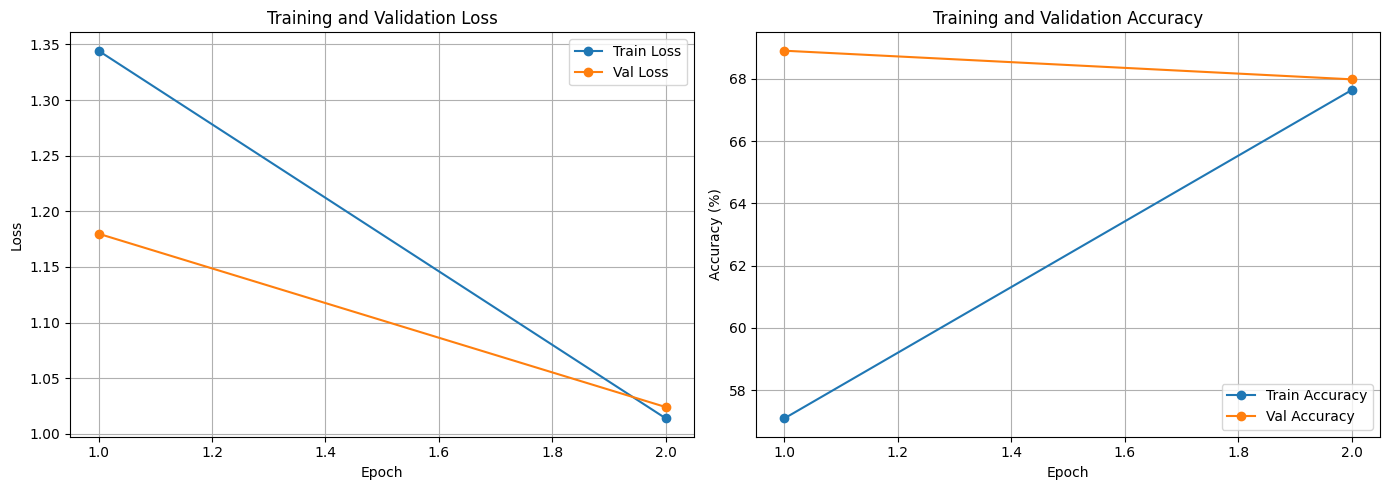

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gc

def train_and_plot(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001,
                   accumulation_steps=4, val_every_n_epochs=2):
    """
    Train the model and plot training/validation metrics.

    Args:
        model: Your chess board model
        train_loader: Training dataloader
        val_loader: Validation dataloader
        num_epochs: Number of epochs to train
        learning_rate: Learning rate for optimizer
        accumulation_steps: Gradient accumulation steps (simulates larger batch)
        val_every_n_epochs: Run validation every N epochs to save time
    """
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")

    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # Setup optimizer with mixed precision
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    # Track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        optimizer.zero_grad()

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Use mixed precision for faster training and less memory
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    loss, predicts = model(images, labels)
                    loss = loss / accumulation_steps  # Normalize loss

                scaler.scale(loss).backward()

                # Update weights every accumulation_steps
                if (batch_idx + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                loss, predicts = model(images, labels)
                loss = loss / accumulation_steps
                loss.backward()

                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps
            train_correct += (predicts == labels).sum().item()
            train_total += labels.numel()

            # Clear memory periodically
            if batch_idx % 10 == 0:
                del images, labels, predicts
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase (only every N epochs)
        if (epoch + 1) % val_every_n_epochs == 0 or epoch == num_epochs - 1:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    if scaler is not None:
                        with torch.cuda.amp.autocast():
                            model.train()
                            loss, predicts = model(images, labels)
                            model.eval()
                    else:
                        model.train()
                        loss, predicts = model(images, labels)
                        model.eval()

                    val_loss += loss.item()
                    val_correct += (predicts == labels).sum().item()
                    val_total += labels.numel()

                    # Clear memory
                    del images, labels, predicts
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

            avg_val_loss = val_loss / len(val_loader)
            val_acc = 100 * val_correct / val_total
            val_losses.append(avg_val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            # Append previous val metrics for plotting
            if val_losses:
                val_losses.append(val_losses[-1])
                val_accs.append(val_accs[-1])

        # Clear cache after each epoch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
    if val_losses:
        ax1.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy', marker='o')
    if val_accs:
        ax2.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }


model = ChessBoardResNet50()

train_loader, val_loader, piece_to_idx = create_dataloaders(
    train_images=train_images,
    train_labels=train_labels,
    val_images=val_images,
    val_labels=val_labels,
    batch_size=8,
    num_workers=0
)

trained_model, history = train_and_plot(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=2,
    learning_rate=0.001,
    accumulation_steps=4,  # Simulates batch size of 8*4=32
    val_every_n_epochs=1
)

In [ ]:
def test_model(model, test_loader):
    """
    Test the trained model on test data.

    Args:
        model: Trained model
        test_loader: Test dataloader

    Returns:
        Dictionary with test metrics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0

    all_predictions = []
    all_labels = []

    print("Testing model...")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions (need to temporarily set to train mode to get loss)
            model.train()
            loss, predicts = model(images, labels)
            model.eval()

            test_loss += loss.item()
            test_correct += (predicts == labels).sum().item()
            test_total += labels.numel()

            all_predictions.extend(predicts.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total

    print(f"\n{'='*50}")
    print(f"TEST RESULTS")
    print(f"{'='*50}")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Correct Predictions: {test_correct}/{test_total}")
    print(f"{'='*50}\n")

    return {
        'test_loss': avg_test_loss,
        'test_acc': test_acc,
        'predictions': all_predictions,
        'labels': all_labels
    }


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create test dataloader
test_loader = DataLoader(
    ChessBoardListDataset(test_images, test_labels, transform=val_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0
)

# Test the model
test_results = test_model(trained_model, test_loader)

Testing model...

TEST RESULTS
Test Loss: 0.9996
Test Accuracy: 65.72%
Correct Predictions: 2187/3328



In [ ]:
def detailed_test_model(model, test_loader, piece_to_idx):
    """Test with per-class accuracy breakdown"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    idx_to_piece = {v: k for k, v in piece_to_idx.items()}
    per_class_correct = {i: 0 for i in range(len(piece_to_idx))}
    per_class_total = {i: 0 for i in range(len(piece_to_idx))}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            model.train()
            loss, predicts = model(images, labels)
            model.eval()

            # Count per-class accuracy
            for i in range(len(piece_to_idx)):
                mask = (labels == i)
                per_class_total[i] += mask.sum().item()
                per_class_correct[i] += ((predicts == labels) & mask).sum().item()

    # Print per-piece accuracy
    print("\nPer-Piece Accuracy:")
    print("-" * 40)
    for i in range(len(piece_to_idx)):
        piece = idx_to_piece[i]
        if per_class_total[i] > 0:
            acc = 100 * per_class_correct[i] / per_class_total[i]
            print(f"{piece:6s}: {acc:5.1f}% ({per_class_correct[i]}/{per_class_total[i]})")

    return per_class_correct, per_class_total

# Use this for more detailed results
per_class_results = detailed_test_model(trained_model, test_loader, piece_to_idx)
print(per_class_results)


Per-Piece Accuracy:
----------------------------------------
x     :  95.2% (1976/2075)
P     :  24.3% (79/325)
N     :   0.0% (0/56)
B     :   0.0% (0/70)
R     :  11.5% (10/87)
Q     :   0.0% (0/39)
K     :   7.7% (4/52)
p     :  34.6% (110/318)
n     :   0.0% (0/63)
b     :   0.0% (0/65)
r     :  11.2% (10/89)
q     :   0.0% (0/37)
k     :   1.9% (1/52)
({0: 1976, 1: 79, 2: 0, 3: 0, 4: 10, 5: 0, 6: 4, 7: 110, 8: 0, 9: 0, 10: 10, 11: 0, 12: 1}, {0: 2075, 1: 325, 2: 56, 3: 70, 4: 87, 5: 39, 6: 52, 7: 318, 8: 63, 9: 65, 10: 89, 11: 37, 12: 52})


Training on: cpu
Epoch 1/4 - Train Loss: 1.6216, Train Acc: 52.77% - Val Loss: 1.4646, Val Acc: 60.23%
Epoch 2/4 - Train Loss: 1.2436, Train Acc: 59.58% - Val Loss: 1.4212, Val Acc: 59.65%
Epoch 3/4 - Train Loss: 1.1965, Train Acc: 61.23% - Val Loss: 1.4351, Val Acc: 62.13%
Epoch 4/4 - Train Loss: 1.1918, Train Acc: 62.22% - Val Loss: 1.4232, Val Acc: 62.41%


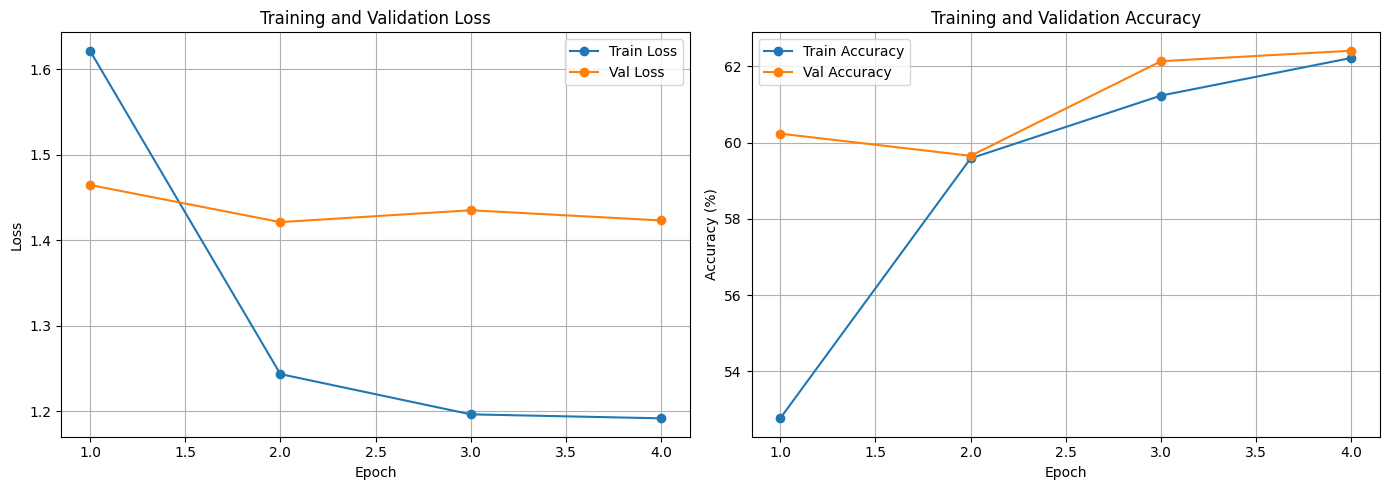

In [ ]:
class ImprovedChessBoardResNet50(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.name = "resnet50"
        self.piece_to_idx = {'x': 0, 'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                             'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12}
        self.class_num = len(self.piece_to_idx)
        board_dim = 8

        self.fex = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.fex.fc.weight.shape[1]
        out_features = board_dim * board_dim * self.class_num
        self.fex.fc = nn.Identity()

        # Increased dropout from 0.1 to 0.3
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(in_features, out_features)

        # Class weights: higher weights for Kings and Queens
        class_weights = torch.ones(self.class_num)
        class_weights[5] = 12   # Q (White Queen)
        class_weights[6] = 12   # K (White King)
        class_weights[11] = 12  # q (Black Queen)
        class_weights[12] = 12  # k (Black King)

        # Move weights to device
        class_weights = class_weights.to(device)
        self.loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, images, labels=None):
        x = self.fex(images)
        x = self.dropout(x)
        x = self.fc(x).view(x.shape[0], 64, self.class_num)  # (batch, 64, 13)

        if not self.training:
            predicts = torch.argmax(x, dim=2)  # (batch, 64)
            return predicts

        # For training: reshape for CrossEntropyLoss
        x = x.permute(0, 2, 1)  # (batch, 13, 64)
        loss = self.loss(x, labels)
        predicts = torch.argmax(x, dim=1)  # (batch, 64)
        return loss, predicts
#
#
updated_model = ImprovedChessBoardResNet50()

train_loader, val_loader, piece_to_idx = create_dataloaders(
    train_images=train_images,
    train_labels=train_labels,
    val_images=val_images,
    val_labels=val_labels,
    batch_size=8,
    num_workers=0
)

trained_model_2, history = train_and_plot(
    model=updated_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=4,
    learning_rate=0.001,
    accumulation_steps=4,  # Simulates batch size of 8*4=32
    val_every_n_epochs=1
)



In [ ]:
per_class_results = detailed_test_model(trained_model, test_loader, piece_to_idx)
print(per_class_results)


Per-Piece Accuracy:
----------------------------------------
x     :  95.7% (1986/2075)
P     :  22.2% (72/325)
N     :   0.0% (0/56)
B     :   0.0% (0/70)
R     :   8.0% (7/87)
Q     :   0.0% (0/39)
K     :  11.5% (6/52)
p     :  34.6% (110/318)
n     :   0.0% (0/63)
b     :   0.0% (0/65)
r     :   7.9% (7/89)
q     :   0.0% (0/37)
k     :   5.8% (3/52)
({0: 1986, 1: 72, 2: 0, 3: 0, 4: 7, 5: 0, 6: 6, 7: 110, 8: 0, 9: 0, 10: 7, 11: 0, 12: 3}, {0: 2075, 1: 325, 2: 56, 3: 70, 4: 87, 5: 39, 6: 52, 7: 318, 8: 63, 9: 65, 10: 89, 11: 37, 12: 52})


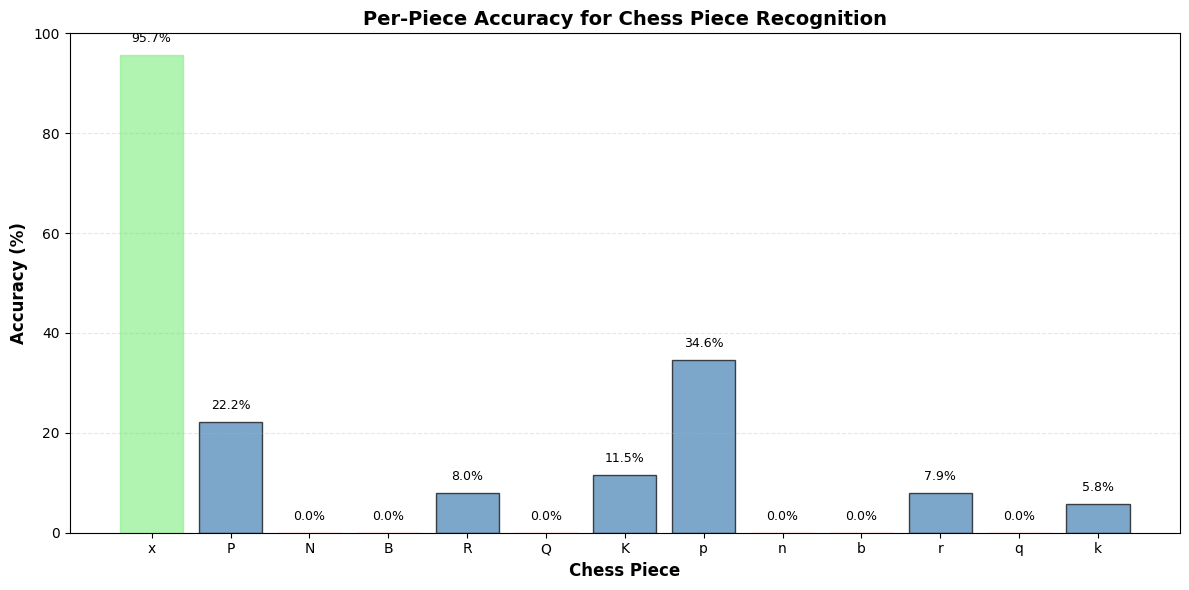

In [ ]:
import matplotlib.pyplot as plt

pieces = ['x', 'P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
accuracies = [95.7, 22.2, 0.0, 0.0, 8.0, 0.0, 11.5, 34.6, 0.0, 0.0, 7.9, 0.0, 5.8]

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(pieces, accuracies, color='steelblue', edgecolor='black', alpha=0.7)

# Color empty squares differently
for i, acc in enumerate(accuracies):
    if acc == 95.7:  # Empty square (x)
        bars[i].set_color('lightgreen')
    elif acc == 0.0:
        bars[i].set_color('salmon')

# Customize the plot
plt.xlabel('Chess Piece', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Piece Accuracy for Chess Piece Recognition', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add accuracy values on top of bars
for i, (piece, acc) in enumerate(zip(pieces, accuracies)):
    plt.text(i, acc + 2, f'{acc}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()